## No winter edition

In [13]:
from SALib.sample.morris import sample
from SALib.analyze.morris import analyze
import numpy as np
from VPRM_offline.src.Offline_VPRM_for_Morris import preprocess_vprm_for_morris
# from VPRM_offline.src.get_modis_point import get_modis_point

from VPRM_offline.src.Offline_VPRM_for_Morris import vprm_station_for_morris
from VPRM_offline.src.Offline_VPRM_for_Morris import flatten_list_2d
from sys import exit
import os
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import differential_evolution

from csv import writer

import Functions
from sklearn.metrics import mean_squared_error
%run Functions.py

cwd = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/'
StationDataPath = cwd + 'data/HH_Data_small/'
# sitename = 'FI-Let' #code of the station
tag = 'Sentinel' #'MODIS', 'MODIS_pp'

iveg = 1 #PFT +1 index of the station
year = 2020 #Year to perform the analysis
input_origin = 'ERA5' #Input origin for the meteorological data
# pathout = '/home/users/rsegura/Scripts/plots/'

stations_file = cwd + 'Stations.csv'
years_file = cwd + 'Station_years.csv'


### 1. Perform a sensitivity Analysis using the Morris Method to obtain the VPRM parameters for each station


In [2]:
stations = pd.read_csv(stations_file, sep = ',', index_col = 0)
# years_st = pd.read_csv(years_file, index_col= 0)
stations, snames = get_stations_year(year)
stations.set_index(stations['Station'], inplace=True)
station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)
station_data.loc[:,'month'] = pd.to_datetime(station_data.index).month.to_list()
station_data = station_data[station_data['month']!= 12]
station_data = station_data[station_data['month']!= 1]
station_data = station_data[station_data['month']!= 2]

for sitename in snames:
    print(sitename)
    
    lon = stations.loc[sitename, 'Longitude']
    lat = stations.loc[sitename, 'Latitude']
    tile = [stations.loc[sitename, 'tile_h'], stations.loc[sitename, 'tile_v']]
    veg_type = stations.loc[sitename, 'VPRM']
    
    df_obs = get_station_observation_year(StationDataPath, sitename, year)
    
    df_obs['month'] = df_obs.date.dt.month
    df_obs = df_obs[df_obs['month']!= 12]
    df_obs = df_obs[df_obs['month']!= 1]
    df_obs = df_obs[df_obs['month']!= 2]
    
    if 'NEE_VUT_REF' in df_obs.columns:
        label = 'NEE_VUT_REF'
    else:
        label = 'FC'

    df_obs.loc[df_obs[label] < -9990, label] = np.nan
    df_obs[label] = df_obs[label]*3600
    df_obs.set_index('TIMESTAMP_START', inplace=True)
    # print(df_obs.head(3))
    
    df_obs = df_obs[[label]]
    NEE_obs = df_obs[label].values

    # EVI, EVImax, EVImin, LSWI, LSWImax, LSWImin, Temp, Rad = preprocess_vprm_for_morris(sitename = sitename, year = year, lat = lat, lon = lon, tile = tile, input_origin = 'ERA5', sat_input = tag)
    # print(type(Temp), Temp.shape)
    df = station_data.filter(regex=sitename)
    Temp = df[sitename + '_TEMP_Station'].to_numpy()
    EVI = df[sitename + '_EVI'].to_numpy()
    LSWI = df[sitename + '_LSWI'].to_numpy()
    Rad = df[sitename + '_RAD_Station'].to_numpy()
    EVImax = np.nanmax(EVI)
    EVImin = np.nanmin(EVI)
    LSWImax = np.nanmax(LSWI)
    LSWImin = np.nanmin(LSWI)
            
    problem = {
        'num_vars': 7,
        'names': ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt'],
        'bounds': [[0.2, 0.45],
                   [100, 250],
                   [0.1, 0.2],
                   [0.0, 1],
                   [-1, 1],
                   [39, 41],
                   [19, 21]]
    }
    X = sample(problem, 1000, num_levels=6)
    
    Y = []
    RMSE = []
        
    for i in range(len(X)):
        GEE, RSP, NEE = vprm_station_for_morris(sitename, year, iveg, X[i], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
        df_case = df_obs.copy(deep=True)
        df_case['Simulated GEE'] = GEE
        df_case['Simulated RSP'] = RSP
        df_case['Simulated NEE'] = NEE
        mean_NEE = df_case['Simulated NEE'].mean()
        Y.append(mean_NEE)
        df_case = df_case.dropna(axis=0)
        RMSE.append(np.mean((df_case['Simulated NEE'] - df_case[label]) ** 2) ** .5)
    """
    6. Analyze  Morris indices
    """
    Y = np.array(Y)

    Si = analyze(problem, X, Y, conf_level=0.95,
                 print_to_console=True, num_levels=6)
    ind = np.where(RMSE == np.min(RMSE))[0][0]
    print(X[ind])
    GEE, RSP, NEE = vprm_station_for_morris(sitename, year, iveg, X[ind], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
    print(NEE.shape)
    df_opt = df_obs.copy(deep=True)
    wrf_convert = 24*44/1000000
    df_opt['NEE'] = NEE*wrf_convert
    df_opt[label] = df_opt[label]*wrf_convert
    unit = '($\mathrm{g_{CO_2} m^{-2} day^{-1}}$)'
    row_contents = list(X[ind]) + [sitename] + [veg_type]
    print(row_contents)
    append_list_as_row('Oslo_analysis/VPRMoutput/best_fit_morris_nowinter_'+str(year)+'.csv', row_contents)


FI-Hyy
                     mu       mu_star         sigma  mu_star_conf
lambdaGPP -11684.014221  11684.014221  2.186331e+03  1.383050e+02
radZero    -8239.275875   8239.275875  2.277177e+03  1.302792e+02
alpha       4715.645345   4715.645345  2.869117e-11  3.583114e-12
beta        3600.000000   3600.000000  1.505548e-12  0.000000e+00
Tmin         239.091432    239.091432  7.617962e+01  5.397434e+00
Tmax         -77.211673     77.211673  2.420162e+01  1.411133e+00
Topt         287.425485    287.425485  9.317921e+01  5.108235e+00
[ 2.00e-01  2.50e+02  1.80e-01  1.00e+00 -6.00e-01  4.10e+01  1.94e+01]
(13200,)
[0.2, 250.0, 0.18000000000000002, 1.0, -0.6, 41.0, 19.4, 'FI-Hyy', 0]
FI-Let
                     mu       mu_star         sigma  mu_star_conf
lambdaGPP -11045.652396  11045.652396  2.117861e+03    136.882371
radZero    -7959.951211   7959.951211  2.227932e+03    147.382556
alpha       3707.071995   3707.071995  1.669436e+01      0.923775
beta        3600.000000   3600.000000  1.60

In [3]:
print(snames)

['FI-Hyy' 'FI-Let' 'FI-Qvd' 'SE-Ros' 'SE-Svb' 'SE-Deg' 'SE-Htm' 'SE-Nor']



### 2. Use different methods to update Parameters (RECO)
#### 2.1 Load the best fit morris paramteters (previous cell)

In [14]:
stations = pd.read_csv(stations_file, sep = ',', index_col = 0)
# years_st = pd.read_csv(years_file, index_col= 0)
stations, snames = get_stations_year(year)
# stations.set_index(stations['Station'], inplace=True)

In [28]:
print(snames)
params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_nowinter_'+str(year)+'.csv', header = None)
col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
params.columns = col_list
params.index = params.Station
params
#radZero  	lambdaGPP 	alpha 	beta 	Tmin 	Tmax 	Topt
# default_params = {1:[275.4595, 0.22577703, 0.28773167, -1.09316696, 0., 40, 20.]}

['FI-Hyy' 'FI-Let' 'FI-Qvd' 'SE-Ros' 'SE-Svb' 'SE-Deg' 'SE-Htm' 'SE-Nor']


,lambdaGPP,radZero,alpha,beta,Tmin,Tmax,Topt,Station,iveg
Station,,,,,,,,,
Station,lambdaGPP,radZero,alpha,beta,Tmin,Tmax,Topt,Station,iveg
FI-Hyy,0.2,250.0,0.18,1.0,-0.6,41.0,19.4,FI-Hyy,0
FI-Let,0.25,250.0,0.2,1.0,0.1999999999999999,40.6,19.0,FI-Let,0
FI-Qvd,0.25,250.0,0.2,1.0,-0.6,39.4,19.0,FI-Qvd,5
SE-Ros,0.35,220.0,0.2,0.8,-1.0,40.2,19.0,SE-Ros,0
SE-Svb,0.35,220.0,0.2,1.0,0.6000000000000001,40.2,19.4,SE-Svb,0
SE-Deg,0.2,100.0,0.1,0.0,1.0,39.4,20.2,SE-Deg,6
SE-Htm,0.35,190.0,0.2,1.0,-0.6,39.4,19.0,SE-Htm,0
SE-Nor,0.25,250.0,0.2,1.0,-0.6,41.0,19.4,SE-Nor,0


#### 2.2 Optimize alpha and beta (RECO) for one station 

In [16]:
#deleted

#### 2.3 Reco predictions with parameters (alpha, beta) optimized with morris, gradient decent and differential evolution for all stations 

In [17]:
# For all stations gradient decent, morris, diff_ev and vprm (wrf) params 
stations, snames = get_stations_year(year)
stations.set_index(stations['Station'], inplace=True)

In [32]:
# df (csv with year) with stationname, updated alpha beta rmse old rmse new for all stations 
df_params_new = pd.DataFrame(index = snames, columns = ['morr_RMSE', 'new_RMSE_gd','new_RMSE_ev', 'alpha_gd', 'beta_gd', 'alpha_ev', 'beta_ev'])
for sitename in snames:
    df = get_station_observation_year(StationDataPath, sitename, year)
    df.date = pd.to_datetime(df.date)
    df['month'] = df['date'].dt.month
    df = df[df['month'] != 12]
    df = df[df['month'] != 2]
    df = df[df['month'] != 1]
     
    # use morris params     
    a = params.loc[sitename]['alpha']
    b = params.loc[sitename]['beta']
    t = df['TA_F']
    print(a,b,t) 
    
    pred = reco(float(a),float(b),t)
    
    old_rmse = m_rmse(df['RECO_DT_VUT_REF'], pred)#df_c['RECO_Pred'])
    
    m,c = lin_reg_grad_dec(a,b,t,df['RECO_DT_VUT_REF'])
    pred_update = reco(m,c,t)
    
    rmse_update = m_rmse(df['RECO_DT_VUT_REF'], pred_update)
    
    # df_params_new.loc[sitename]['Station'] = sitename
    df_params_new.loc[sitename]['morr_RMSE'] = old_rmse
    df_params_new.loc[sitename]['new_RMSE_gd'] = rmse_update
    df_params_new.loc[sitename]['alpha_gd'] = m
    df_params_new.loc[sitename]['beta_gd'] = c 
    
    temp = df['TA_F'].tolist()
    resp = df['RECO_DT_VUT_REF'].tolist()
    bounds = [[0, 0.5],[0.0, 1.2]]
    result = differential_evolution(func_reco, bounds, args = (temp,resp,))

    # print('Status : %s' % result['message'])
    df_params_new.loc[sitename]['alpha_ev'] = result['x'][0]
    df_params_new.loc[sitename]['beta_ev'] = result['x'][1]
    
    pred_update_ev = reco(result['x'][0],result['x'][1],t)
    rmse_update_ev = m_rmse(df['RECO_DT_VUT_REF'], pred_update_ev)
    df_params_new.loc[sitename]['new_RMSE_ev'] = rmse_update_ev
    
    # print(df_params_new)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [ ]:
df_params_new

In [ ]:
#VPRM parameters from WRF
# lambdaGPP 	radZero 	alpha 	beta 	Tmin 	Tmax 	Topt
parameters_wrf = {1:[275.4595, 0.22577703, 0.28773167, -1.09316696, 0., 40, 20.],
              2:[254.4188, 0.21489270, 0.18056630, 0.83641734, 0., 40, 20.,],
              3:[446.0888,0.16293380,0.24447911, -0.48669162, 0., 40, 20.],
              4:[70.3829,0.29311134,0.05464646, -0.12080592, 2., 40, 20.],
              5:[682.0, 0.1141, 0.0049, 0.0000, 2., 40, 20.],
              6:[1132.2, 0.08626603, 0.09231632,0.28788863, 5., 40, 22.],
              7:[527.9303, 0.11930965, 0.1245603, 0.01743361, 2., 40 ,18.],
              8:[0.00, 0.00, 0.00, 0, 0., 40, 0.]
             } 


In [19]:
df_params_new.to_csv('Oslo_analysis/VPRMoutput/best_fit_gd_alpha_beta_nowinter'+str(year)+'.csv')


In [25]:
df_params_new = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_gd_alpha_beta_nowinter'+str(2019)+'.csv', index_col=0)
df_params_new

,morr_RMSE,new_RMSE_gd,new_RMSE_ev,alpha_gd,beta_gd,alpha_ev,beta_ev
FI-Hyy,1.211178,1.127720,1.103042,0.233579,1.048256,0.224084,1.200000
FI-Let,1.743033,1.704387,1.703408,0.169748,0.989961,0.175155,0.904083
FI-Qvd,2.575152,1.979179,1.977330,0.334636,0.997137,0.343102,0.862912
SE-Ros,1.407216,1.367516,1.232604,0.198498,0.504036,0.161130,1.200000
SE-Svb,1.269589,1.265514,1.253368,0.198363,1.032068,0.188954,1.200000
SE-Deg,0.602975,0.344310,0.281140,0.049251,0.035434,0.038285,0.260966
SE-Htm,4.458896,2.686411,2.664545,0.487066,0.971394,0.500000,0.593765
SE-Nor,3.535078,2.284869,2.273438,0.421924,1.058493,0.412455,1.200000


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

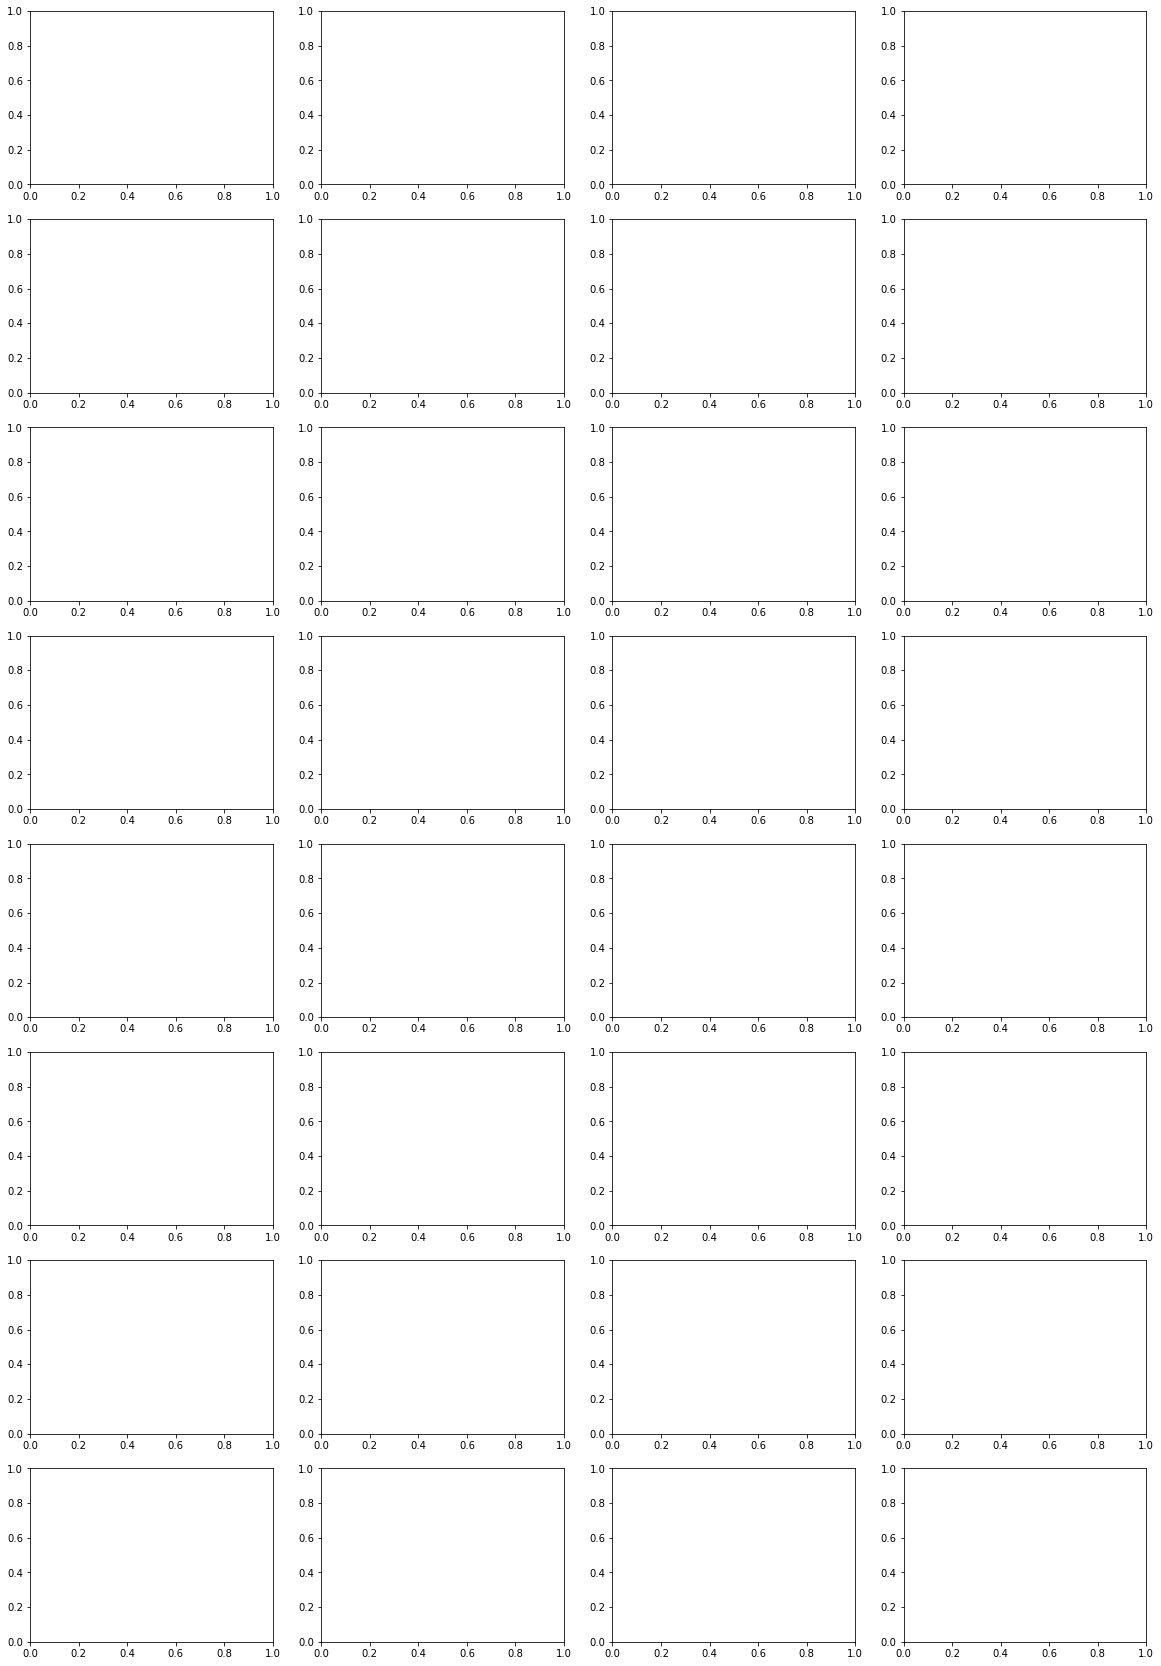

In [26]:
# plots of old and new prediction 
fig, ax = plt.subplots(len(snames), 4, figsize = (20,30))

for i, sitename in enumerate(snames):
    df = get_station_observation_year(StationDataPath, sitename, year)
    #The pred from morris parameters (df params)
    df.date = pd.to_datetime(df.date)
    df['month'] = df['date'].dt.month
    df = df[df['month'] != 12]
    df = df[df['month'] != 2]
    df = df[df['month'] != 1]
    
    a = params.loc[sitename]['alpha']
    b = params.loc[sitename]['beta']
    t = df['TA_F']
    
    pred = reco(a,b,t)
    
    df_c = pd.concat([pred, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_c = df_c.rename(columns = {'TA_F':'RECO_Pred'})
    
    #THe pred from gd parameters (df params new) 
    
    m = df_params_new.loc[sitename]['alpha_gd']
    c = df_params_new.loc[sitename]['beta_gd']
    
    pred_update = reco(m,c,t)
    
    df_u = pd.concat([pred_update, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_u = df_u.rename(columns = {'TA_F':'RECO_Pred'})
    
    #The prediction from wrf parameters (dict parameters_wrf 
    
    iveg = params.at[sitename, 'iveg']
    para_wrf = parameters_wrf[iveg + 1]
    alpha_w = para_wrf[2]
    beta_w = para_wrf[3]
    
    pred_wrf = reco(alpha_w,beta_w,t)
    
    df_w = pd.concat([pred_wrf, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_w = df_w.rename(columns = {'TA_F':'RECO_Pred'})
    
    # print(df_w.head())
    # print(df_u.head())
    
    #The prediction with differential evolution
    ae = df_params_new.loc[sitename]['alpha_ev']
    be = df_params_new.loc[sitename]['beta_ev']
    
    pred_update_e = reco(m,c,t)
    
    df_e = pd.concat([pred_update_e, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_e = df_u.rename(columns = {'TA_F':'RECO_Pred'})
    
    x = pd.to_datetime(df.date)
    # y = df.NEE_VUT_REF
    # yn = df.nans
    ax[i,0].plot(x,df_c['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,0].plot(x,df_c['RECO_Pred'], label = 'Pred_mor')

    ax[i,0].set_title(f'RECO {sitename, year} morris alpha, beta')
    ax[i,0].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)
    
    ax[i,1].plot(x,df_u['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,1].plot(x,df_u['RECO_Pred'], label = 'Pred_gd')

    ax[i,1].set_title(f'RECO {sitename, year} gradient decent alpha, beta')
    ax[i,1].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)   
    
    ax[i,2].plot(x,df_w['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,2].plot(x,df_w['RECO_Pred'], label = 'Pred_wrf')

    ax[i,2].set_title(f'RECO {sitename, year} wrf parameters')
    ax[i,2].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)
    
    ax[i,3].plot(x,df_e['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,3].plot(x,df_e['RECO_Pred'], label = 'Pred_ev')

    ax[i,3].set_title(f'RECO {sitename, year} diff evolution parameters')
    ax[i,3].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)


In [ ]:
# plot diurnal of old and new prediction 
fig, ax = plt.subplots(len(snames), figsize = (10,30))

begin = pd.date_range(str(year) + "-03-01", periods=9, freq = "MS")
end = pd.date_range(str(year) +"-03-01", periods=9, freq="M")
label = 'Original' 
# unit = '($\mathrm{g_{CO_2} m^{-2} day^{-1}}$)'

for i, sitename in enumerate(snames):
# for sitename in snames: 
    '''
    1. Get the station observation 
    '''
    df = get_station_observation_year(StationDataPath, sitename, year)
    df.date = pd.to_datetime(df.date)
    df['month'] = df['date'].dt.month
    df = df[df['month'] != 12]
    df = df[df['month'] != 2]
    df = df[df['month'] != 1]
    
    a = params.loc[sitename]['alpha']
    b = params.loc[sitename]['beta']
    t = df['TA_F']  
    pred = reco(a,b,t)   
    df_c = pd.concat([pred, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_c = df_c.rename(columns = {'TA_F':'RECO_Pred_morr'})
    
    m = df_params_new.loc[sitename]['alpha_gd']
    c = df_params_new.loc[sitename]['beta_gd']
    pred_update = reco(m,c,t)
    df_u = pd.DataFrame(pred_update)
    # df_u = pd.concat([pred_update, df[['RECO_DT_VUT_REF']]], axis = 1)
    df_u = df_u.rename(columns = {'TA_F':'RECO_Pred'})
    
    ae = df_params_new.loc[sitename]['alpha_ev']
    be = df_params_new.loc[sitename]['beta_ev']
    pred_update_e = reco(ae,be,t)
    df_e = pd.DataFrame(pred_update_e)
    # df_u = pd.concat([pred_update, df[['RECO_DT_VUT_REF']]], axis = 1)
    df_e = df_e.rename(columns = {'TA_F':'RECO_Pred_ev'})
    
    iveg = params.at[sitename, 'iveg']
    para_wrf = parameters_wrf[iveg + 1]
    alpha_w = para_wrf[2]
    beta_w = para_wrf[3]
    
    pred_wrf = reco(alpha_w,beta_w,t)
    df_w = pd.DataFrame(pred_wrf)
    # df_w = pd.concat([pred_wrf, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_w = df_w.rename(columns = {'TA_F':'RECO_Pred_wrf'})
        
    df = pd.concat([df_c, df_u, df_w, df_e], axis = 1)#.reset_index(drop=True)
        
    '''
    4. Subplot Journal 
    '''
    morr_reco = []
    obs_reco = []
    opt_reco = []
    wrf_reco=[]
    ev_reco = []
    df.index = pd.to_datetime(df['date'])
    
    for month in range(len(begin)):
        df_opt_m = df[begin[month]:end[month]]
        df_opt_mean = df_opt_m.groupby([df_opt_m.index.hour]).mean()
        obs_reco.append(df_opt_mean['RECO_DT_VUT_REF'])

        morr_reco.append(df_opt_mean['RECO_Pred_morr'])
        
        opt_reco.append(df_opt_mean['RECO_Pred'])
        
        wrf_reco.append(df_opt_mean['RECO_Pred_wrf'])
        
        ev_reco.append(df_opt_mean['RECO_Pred_ev'])

            
    obs_reco = flatten_list_2d(obs_reco)
    opt_reco = flatten_list_2d(opt_reco)
    morr_reco = flatten_list_2d(morr_reco)
    wrf_reco = flatten_list_2d(wrf_reco)
    ev_reco = flatten_list_2d(ev_reco)

    time_day = np.arange(0,len(obs_reco))

    ax[i].plot(time_day, obs_reco, linewidth=1.5, color='k', label='OBS')
    ax[i].plot(time_day, opt_reco, linewidth=1.5, color = 'violet', label='Pred')
    ax[i].plot(time_day, morr_reco, linewidth=1.5, color = 'y', label='Pred_morr')
    ax[i].plot(time_day, wrf_reco, linewidth=1.5, color = 'g', label='Pred_wrf')
    ax[i].plot(time_day, ev_reco, linewidth=1.5, color = 'b', label='Pred_ev')


    legend=ax[i].legend(loc='upper left', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)#, bbox_to_anchor=(1., 0.512))
    ax[i].set_xlim(0, 216)
    ax[i].set_ylim(-2, 12)
    for tt in range(24,216,24):
        ax[i].axvline(tt, color='grey', linewidth=0.8)
    ax[i].axhline(0, color='grey', linewidth=0.8, linestyle='--')
    # ax[i].set_ylabel('Flux '+unit, fontsize=10)
    major_ticks = np.arange(0, 216, 12)
    minor_ticks = np.arange(0, 216, 2)
    ax[i].xaxis.set_ticks(major_ticks)
    ax[i].set_xticklabels(['', 'Mar\n'+str(year),'','Apr','','May','','Jun','','Jul','','Aug','','Sep','','Oct','','Nov'])
    ax[i].xaxis.set_ticks(minor_ticks, minor = True)
    ax[i].xaxis.set_tick_params(which='major', labelsize=8)
    ax[i].set_title(sitename +' '+ str(year) + ' (RECO) ', fontsize=11)
# fig.savefig(cwd +'figures/'+ str(year)+'_stations_hh.png')   # save the figure to file

# fig1.savefig(cwd +'figures/'+str(year)+'_stations_diurnal.png')   # save the figure to file


### 3. Use different methods to update Parameters (GPP)


#### 3.1. OPtimize for one Station and year

In [ ]:
params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_nowinter_'+str(year)+'.csv', header = None)
col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
params.columns = col_list
params.index = params.Station
params

In [22]:
# df (csv with year) with stationname, updated alpha beta rmse old rmse new for all stations 
df_params_gpp = pd.DataFrame(index = snames, columns = ['morr_RMSE', 'new_RMSE_gd','new_RMSE_ev', 'lambdaGPP_gd', 'radZero_gd', 'lambdaGPP_ev', 'radZero_ev'])
station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)
station_data.loc[:,'month'] = pd.to_datetime(station_data.index).month.to_list()
station_data = station_data[station_data['month']!= 12]
station_data = station_data[station_data['month']!= 1]
station_data = station_data[station_data['month']!= 2]

for sitename in snames:
    print(sitename) 
    #get morris optimized parameters, meterological data and sentinel data 
    lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GPP_or = load_data_gpp(params, station_data, sitename, year, StationDataPath, months = True)
    
    print('lamda: ', lambdaGPP, 'tscale: ', Tscale.shape, 'wscale: ', Wscale.shape, 'pscale: ', Pscale.shape, 'evi: ', EVI.shape, 'rad: ', Rad.shape, 'radZ: ', radZero,'original: ', GPP_or.shape)
        
    #  predition wirth morris optimized parameters
    gee = GEE_calculate(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero)
    old_rmse = m_rmse(GPP_or, gee)
    
    # optimize params with gd     
    lambda_lr, rZ_lr = gpp_grad_dec(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GPP_or, L = 0.0001, epochs = 2000)
    
    gee_gd = GEE_calculate(lambda_lr, Tscale, Wscale, Pscale, EVI, Rad, rZ_lr)
    rmse_gd = m_rmse(GPP_or, gee_gd)
    
    # optimize params with diff evolution
    a = [lambdaGPP-0.1, lambdaGPP+0.1]
    b = [radZero-50, radZero+50]
    bounds = [a,b]
    result = differential_evolution(func_gee, bounds, args = (Tscale, Wscale, Pscale, EVI, Rad, GPP_or,))
    solution = result['x']
    
    gee_ev = GEE_calculate(solution[0], Tscale, Wscale, Pscale, EVI, Rad, solution[1])
    rmse_ev = m_rmse(GPP_or, gee_ev) 
    
    # df_params_gpp.loc[sitename]['Station'] = sitename
    df_params_gpp.loc[sitename]['morr_RMSE'] = old_rmse
    
    df_params_gpp.loc[sitename]['new_RMSE_gd'] = rmse_gd
    df_params_gpp.loc[sitename]['lambdaGPP_gd'] = lambda_lr
    df_params_gpp.loc[sitename]['radZero_gd'] = rZ_lr 
    
    df_params_gpp.loc[sitename]['new_RMSE_ev'] = rmse_ev
    df_params_gpp.loc[sitename]['lambdaGPP_ev'] = solution[0]
    df_params_gpp.loc[sitename]['radZero_ev'] = solution[1]
    

FI-Hyy


TypeError: list indices must be integers or slices, not str

In [23]:
df_params_gpp.to_csv('Oslo_analysis/VPRMoutput/best_fit_gd_lambda_radZero_nowinter'+str(year)+'.csv')

In [24]:
df_params_gpp

,morr_RMSE,new_RMSE_gd,new_RMSE_ev,lambdaGPP_gd,radZero_gd,lambdaGPP_ev,radZero_ev
FI-Hyy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FI-Let,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FI-Qvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SE-Ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SE-Svb,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SE-Deg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SE-Htm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SE-Nor,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# missing plots? 

Old ideas!